# Final Project

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandoc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings("ignore")
echo = False

In [2]:
# Reading in data
# Skip 2020 due to shortened season
years = ['23', '22', '21', '19', '18', '17', '16', '15', '14', '13']
for year in years:
    standings = f'standings{year}'
    hittingPlayers = f'hittingPlayers{year}'
    pitchingPlayers = f'pitchingPlayers{year}'
    
    globals()[standings] = pd.read_csv(f'Baseball_Team_Standings_20{year}.csv')
    globals()[hittingPlayers] = pd.read_csv(f'Baseball_Hitting_Player_20{year}.csv')
    globals()[pitchingPlayers] = pd.read_csv(f'Baseball_Pitching_Player_20{year}.csv')

# len(hittingPlayers23)

## Intro

In the competitive landscape of Major League Baseball (MLB), the pursuit of victory is incessant. Teams invest significant resources in assembling a roster of talented players, each meticulously chosen for their unique skills and contributions to the game. Yet, in the quest for success, the ability to predict team performance remains an elusive but paramount goal for managers and fans alike. 

Managers often find their job security tethered to the team's success, as their ability to predict wins can determine whether they remain at the helm or face termination. For fans, the stakes can be equally high, especially when considering the emotional rollercoaster of supporting a team throughout a season. Whether it's for the thrill of sports betting or simply to brace oneself for potential disappointment, the desire to accurately forecast team outcomes is deeply ingrained in the fabric of baseball fandom.

In this analysis, we delve into the intricate world of MLB statistics, leveraging the performance data of top players from each team to forecast team wins. Statistical analysis serves as a powerful tool, offering insights into player capabilities, team dynamics, and potential outcomes of the season. By examining key metrics and employing advanced statistical techniques, we aim to unravel the complex interplay between individual player performance and team success.

Using a comprehensive dataset encompassing both batting and pitching statistics of top MLB players, we will attempt to construct predictive models capable of estimating the number of wins each team achieved in a given season.

As we begin this analysis, it's crucial to recognize the unpredictable essence of sports. While statistics may not capture every aspect of the game, our use of data and a systematic approach aims to reveal the insights concealed within the numbers.


Goal: Predict wins with top players stats
SubGoals:
    Show stat correlations
    Does hitting or pitching matter more?

## Data Exploration

Next, we'll dig into the original dataset, using what we know about baseball to pick out the most important stats for both hitters and pitchers. We'll look at the data closely, blending our understanding of the game with careful analysis to find the numbers that really matter for assessing how players perform and how their teams succeed.

To kick things off, we'll use confusion matrices to help us spot stats that might be too similar to each other. We will then choose which statistics best fit each core tool that MLB scouts and managers use to determine a players impact on the game.

In [3]:
# pitchingPlayers23.head()
# pitchingPlayers23.columns

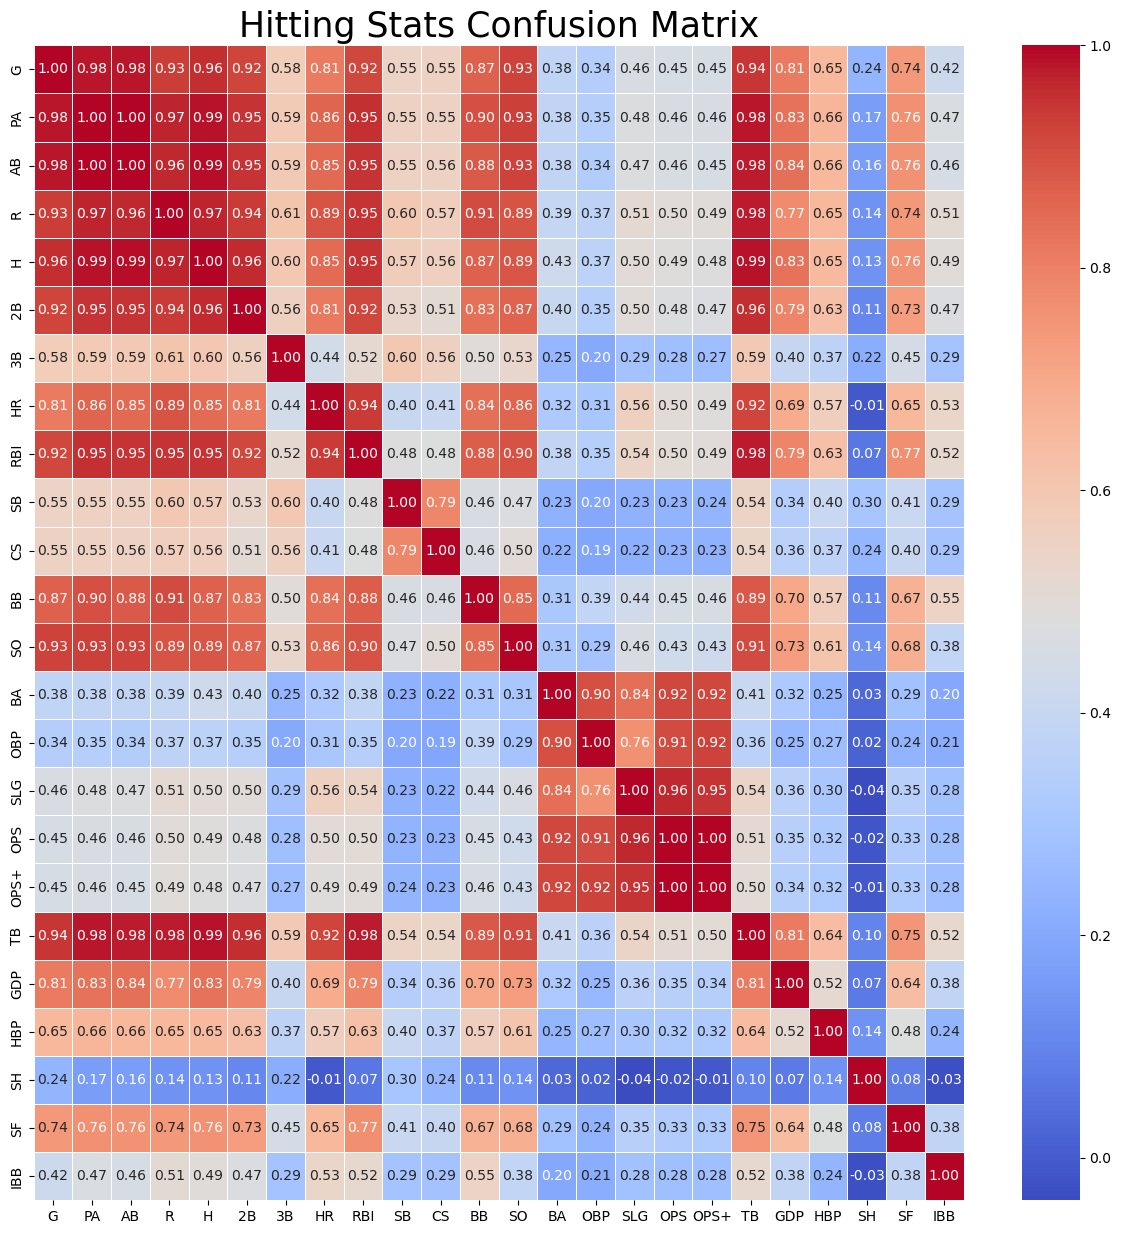

In [4]:
hittingPlayersCorr =  hittingPlayers23.drop(columns=["Rk", "Age", "Name","Tm", "Lg", "Pos Summary", "Name-additional"])

correlation_matrix = hittingPlayersCorr.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths= 0.5)
plt.title("Hitting Stats Confusion Matrix", fontsize=25)
plt.show()

### Legend:

- **G:** Games Played
- **PA:** Plate Appearances
- **AB:** At Bats
- **R:** Runs Scored
- **H:** Hits
- **2B:** Doubles
- **3B:** Triples
- **HR:** Home Runs
- **RBI:** Runs Batted In
- **SB:** Stolen Bases
- **CS:** Caught Stealing
- **BB:** Walks (Base on Balls)
- **SO:** Strikeouts
- **BA:** Batting Average
- **OBP:** On-Base Percentage
- **SLG:** Slugging Percentage
- **OPS:** On-Base Plus Slugging
- **OPS+:** Adjusted OPS (OPS adjusted for league and park factors)
- **TB:** Total Bases
- **GDP:** Ground Into Double Play
- **HBP:** Hit By Pitch
- **SH:** Sacrifice Hits
- **SF:** Sacrifice Flies
- **IBB:** Intentional Walks

### Top Qualities for Hitters:

- **Endurance:** G, PA, AB
- **Contact:** H, BA
- **Power:** HR, SLG
- **Patience:** BB, OBP
- **Speed:** SB

Runs and Runs Batted In exhibit a strong dependence on team context. Raw statistics like Hits, Home Runs, Walks, and Stolen Bases can be influenced by a player's endurance, introducing skewness to the data. On the other hand, percentages such as Batting Average, Slugging Percentage, and On-Base Percentage are not as affected by availability.

To ensure a comprehensive analysis, both raw numbers and percentages will be considered. However, since endurance is inherently captured in the raw numbers, there won't be a separate endurance statistics included in this analysis.

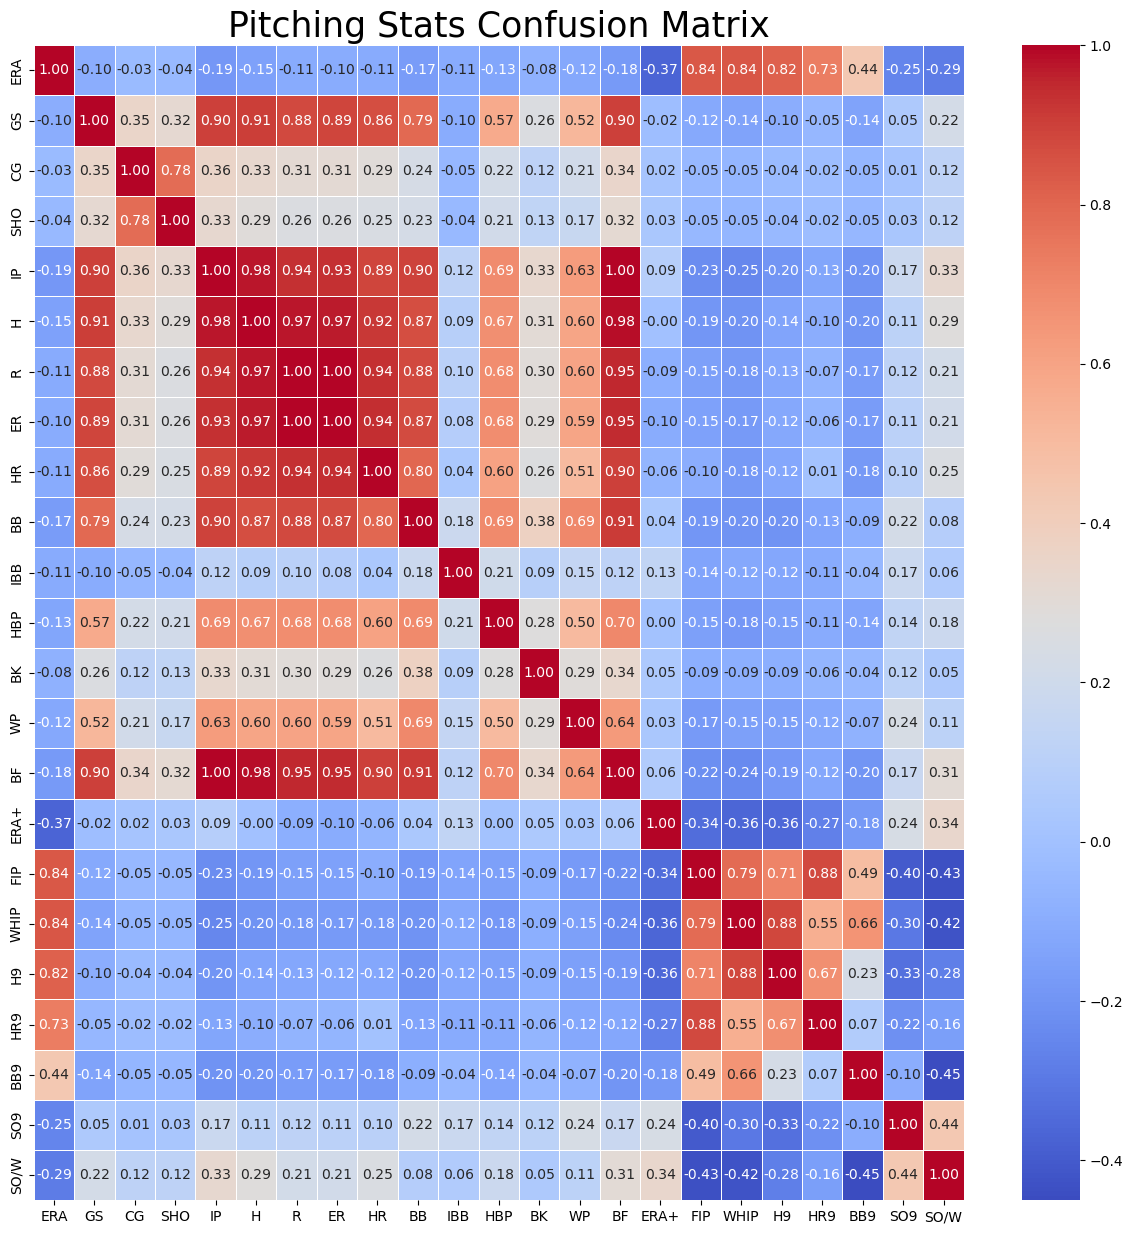

In [5]:
pitchingPlayersCorr =  pitchingPlayers23.drop(columns=["Rk", "Age", "Name","Tm", "Lg", "W", "L", "W-L%", "G", "GF", "SV", "SO", "Name-additional"])

correlation_matrix = pitchingPlayersCorr.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths= 0.5)
plt.title("Pitching Stats Confusion Matrix", fontsize=25)
plt.show()

### Legend:
- **ERA:** Earned Run Average
- **GS:** Games Started
- **CG:** Complete Games
- **IP:** Innings Pitched
- **H:** Hits Allowed
- **R:** Runs Allowed
- **ER:** Earned Runs Allowed
- **HR:** Home Runs Allowed
- **BB:** Walks (Base on Balls) Allowed
- **IBB:** Intentional Walks Allowed
- **SO:** Strikeouts
- **HBP:** Hit By Pitch
- **BK:** Balks
- **WP:** Wild Pitches
- **BF:** Batters Faced
- **ERA+:** Adjusted ERA (ERA adjusted for league and park factors)
- **FIP:** Fielding Independent Pitching
- **WHIP:** Walks plus Hits per Inning Pitched
- **H9:** Hits Allowed per 9 Innings
- **HR9:** Home Runs Allowed per 9 Innings
- **BB9:** Walks Allowed per 9 Innings
- **SO9:** Strikeouts per 9 Innings
- **SO/W:** Strikeouts-to-Walks Ratio

### Top Qualities for Pitchers:

- **Endurance:** GS, CG, IP
- **Limiting Hits:** H, H9
- **Limiting Home Runs:** HR, HR9
- **Limiting Walks:** BB, BB9
- **Expanding Strikeouts:** SO, SO9

Raw statistics like Hits, Home Runs, Walks, and Strikeouts can be influenced by a player's endurance, introducing skewness to the data. On the other hand, ratios such as Hits Allowed per 9 Innings, Home Runs Allowed per 9 Innings, Walks Allowed per 9 Innings, and Strikeouts per 9 Innings are not as affected by endurance.

Just like with the hitter statistics, both raw numbers and percentages will be considered and no endurance statistics will be included.

In [6]:
#Standings
def cleanStandings(standings, year):
    standings = standings.dropna()
    standings["Rk"] = standings["Rk"].astype(int)
    standings = standings.set_index("Rk",drop=True)
    standings = standings[['Tm', 'W']]
    abbreviations = pd.read_csv("TeamAbbreviations.csv")
    standings = pd.merge(standings, abbreviations, on ='Tm').drop(columns=['Tm']).rename(columns={'Team': 'Tm'})
    standings['Tm'] = standings['Tm'] + f'{year}'
#     standings = standings.set_index('Tm')
    return standings

# Hitters
def cleanHitters(hittingPlayers):
    # Keep only a few columns
    hittingPlayers = hittingPlayers[['Name', 'Tm', 'PA', 'H', 'HR', 'BB', 'SB', 'BA', 'OBP', 'SLG']]
    hittingPlayers['Name'] = hittingPlayers['Name'].astype(str)

    hittingPlayers = hittingPlayers.dropna()
    # Clean player names
    hittingPlayers['Name'] = hittingPlayers['Name'].str.replace('*', '', regex=False)
    hittingPlayers['Name'] = hittingPlayers['Name'].str.replace('#', '', regex=False)
    #Set min PAs
    minPAs = 200
    hittingPlayers = hittingPlayers[hittingPlayers["PA"] > minPAs]
    hittingPlayers = hittingPlayers.drop(columns=['PA'])
    hittingPlayers = hittingPlayers[hittingPlayers['Tm'] != 'TOT']
    hittingPlayers = hittingPlayers.set_index('Name')
    return hittingPlayers

# Pitchers
def cleanPitchers(pitchingPlayers):
    # Keep only a few columns
    pitchingPlayers = pitchingPlayers[['Name', 'Tm', 'IP', 'H', 'HR', 'BB', 'SO', 'H9',  'HR9', 'BB9', 'SO9']]
    pitchingPlayers['Name'] = pitchingPlayers['Name'].astype(str)

    pitchingPlayers = pitchingPlayers.dropna()
    # Clean player names
    pitchingPlayers['Name'] = pitchingPlayers['Name'].str.replace('*', '', regex=False)
    pitchingPlayers['Name'] = pitchingPlayers['Name'].str.replace('#', '', regex=False)
    #Set min IPs
    minIPs = 73
    pitchingPlayers = pitchingPlayers[pitchingPlayers['IP'] > minIPs]
    pitchingPlayers = pitchingPlayers.drop(columns=['IP'])
    pitchingPlayers = pitchingPlayers[pitchingPlayers['Tm'] != 'TOT']
    pitchingPlayers = pitchingPlayers.set_index('Name')
    return pitchingPlayers

In [7]:
# Clean all hitters, pitchers and standings
years = ['23', '22', '21', '19', '18', '17', '16', '15', '14', '13']
for year in years:
    standings = f'standings{year}'
    hittingPlayers = f'hittingPlayers{year}'
    pitchingPlayers = f'pitchingPlayers{year}'
    
    globals()[standings] = cleanStandings(globals()[standings], year)
    
    globals()[hittingPlayers] = cleanHitters(globals()[hittingPlayers])
    globals()[hittingPlayers]['Tm'] = globals()[hittingPlayers]['Tm'] + f'{year}'
    
    globals()[pitchingPlayers] = cleanPitchers(globals()[pitchingPlayers])
    globals()[pitchingPlayers]['Tm'] = globals()[pitchingPlayers]['Tm'] + f'{year}'

Here are a few players from the 2023 season along with the statistics we've selected for our analysis based on the confusion matrices. We limited hitters to with a minimum of 200 plate appearances and pitchers to a minimum of 73 innings pitched. 73 innings was chosen since it is 5% of the expected innings pitched for a team in a season (162 games of 9 innings).

In [8]:
hittingPlayers23.head()

,Tm,H,HR,BB,SB,BA,OBP,SLG
Name,,,,,,,,
CJ Abrams,WSN23,138,18,32,47,0.245,0.300,0.412
José Abreu,HOU23,128,18,42,0,0.237,0.296,0.383
Ronald Acuna Jr.,ATL23,217,41,80,73,0.337,0.416,0.596
Willy Adames,MIL23,120,24,71,5,0.217,0.310,0.407
Nick Ahmed,ARI23,42,2,12,5,0.212,0.257,0.303


In [9]:
pitchingPlayers23.head()

,Tm,H,HR,BB,SO,H9,HR9,BB9,SO9
Name,,,,,,,,,
Andrew Abbott,CIN23,100,16,44,120,8.2,1.3,3.6,9.9
Sandy Alcántara,MIA23,176,22,48,151,8.6,1.1,2.3,7.4
Logan Allen,CLE23,127,16,48,119,9.1,1.1,3.4,8.5
Chase Anderson,COL23,88,17,32,62,9.7,1.9,3.5,6.9
Tyler Anderson,LAA23,146,20,64,119,9.3,1.3,4.1,7.6


In [10]:
standings23temp = standings23.set_index('Tm')
#standings23temp.head()

# Finding Player Values (Methodology)

In [11]:
# Generate weights for each stat
def genWeights(count):
    while True:
        weights = []
        for i in range(count-1):
            weight = np.random.randint(1, 30)
            weights.append(weight)
        weights.append(100-sum(weights))
        random.shuffle(weights)
        if all(weight > 0 for weight in weights):
            return weights

In [12]:
# Create Value Metric
def playerValue(players, weights, typePlayer):
    hitting_stats = ['H', 'HR', 'BB', 'SB', 'BA', 'OBP', 'SLG']
    pitching_stats = ['H', 'HR', 'BB', 'SO', 'H9',  'HR9', 'BB9', 'SO9']
    scaler = MinMaxScaler()
    
    if typePlayer == "Hitter":
        # Normalize values due to discrepancy in ranges of values for different statistics
        for stat in players.columns[1:8]:
            players[[stat+ '_norm']] = scaler.fit_transform(players[[stat]])

        # Calculate and normalize weighted value
        for i, column in enumerate(players.columns[8:16]):
            mean_value = players[column].mean()
            weight = weights[i]
            players[column + '_val'] = (players[column] - mean_value) * weight
        
        players['Value'] = players.iloc[:, [15,16,17,18,19,20,21]].sum(axis=1)
        players = players.iloc[:, [0,1,2,3,4,5,6,7,22]]
        players = players.sort_values('Value', ascending=False)
    
    elif typePlayer == "Pitcher":
        # Negate Strikeouts because higher is better
        players['SOadj'] = -players['SO']
        players['SO9adj'] = -players['SO9']
        # Normalize values due to discrepancy in ranges of values for different statistics
        for stat in players.iloc[:, [1, 2, 3, 5, 6, 7, 9, 10]]:
            players[[stat+ '_norm']] = scaler.fit_transform(players[[stat]])
            
        for i, column in enumerate(players.columns[11:20]):
            mean_value = players[column].mean()
            weight = weights[i]
            players[column + '_val'] = (mean_value - players[column]) * weight
        
        players['Value'] = players.iloc[:, [19,20,21,22,23,24,25,26]].sum(axis=1)
        players = players.iloc[:, [0,1,2,3,4,5,6,7,8,27]]
        players = players.sort_values('Value', ascending=False)
    
    else:
        raise ValueError("Player type unavailable.")

    return players

To assess the value of each player, we will allocate random weights to the statistics identified as indicative of a player's significance. Subsequently, we will standardize each statistic across all players within a specific year and then multiply them by the randomly assigned weights. The cumulative value for a player will be determined by summing the individual values attributed to each statistic.

In this demonstration, we will evenly distribute the weights. This approach aims to highlight players who exhibit well-rounded skills rather than excelling in just one area. Notably, in the 2023 season, two teams boasted two of the top five hitters in the league: the Braves with Acuna Jr. and Olson, and the Dodgers with Freeman and Betts. Moreover, Acuna Jr. emerged as the standout hitter of 2023, providing more than double the value of the 10th best hitter.

Conversely, the top pitchers displayed more comparable values. Yet similary to the hitters, two teams boasted two of the top ten pitchers in the league: the Braves with Fried and Strider, and the Tigers with Skubal and Holton.

In [13]:
# hitterWeights = genWeights(7)

hitterWeights = [14.3,14.3,14.3,14.3,14.3,14.3,14.3]
print(f'''Hitter Weights: 
H: {hitterWeights[0]}%
HR: {hitterWeights[1]}%
BB: {hitterWeights[2]}%
SB: {hitterWeights[3]}%
BA: {hitterWeights[4]}%
OBP: {hitterWeights[5]}%
SLG: {hitterWeights[6]}%
''')

Hitter Weights: 
H: 14.3%
HR: 14.3%
BB: 14.3%
SB: 14.3%
BA: 14.3%
OBP: 14.3%
SLG: 14.3%



In [14]:
hitter23Values = playerValue(hittingPlayers23, hitterWeights, "Hitter")
hitter22Values = playerValue(hittingPlayers22, hitterWeights, "Hitter")
hitter21Values = playerValue(hittingPlayers21, hitterWeights, "Hitter")
hitter19Values = playerValue(hittingPlayers19, hitterWeights, "Hitter")
hitter18Values = playerValue(hittingPlayers18, hitterWeights, "Hitter")
hitter17Values = playerValue(hittingPlayers17, hitterWeights, "Hitter")
hitter16Values = playerValue(hittingPlayers16, hitterWeights, "Hitter")
hitter15Values = playerValue(hittingPlayers15, hitterWeights, "Hitter")
hitter14Values = playerValue(hittingPlayers14, hitterWeights, "Hitter")
hitter13Values = playerValue(hittingPlayers13, hitterWeights, "Hitter")

In [15]:
hitter23Values.head(10)

,Tm,H,HR,BB,SB,BA,OBP,SLG,Value
Name,,,,,,,,,
Ronald Acuna Jr.,ATL23,217,41,80,73,0.337,0.416,0.596,53.900507
Shohei Ohtani,LAA23,151,44,91,20,0.304,0.412,0.654,39.578257
Freddie Freeman,LAD23,211,29,72,23,0.331,0.410,0.567,37.641040
Mookie Betts,LAD23,179,39,96,14,0.307,0.408,0.579,37.199043
Matt Olson,ATL23,172,54,104,1,0.283,0.389,0.604,36.460337
Juan Soto,SDP23,156,35,132,12,0.275,0.410,0.519,33.788776
Corey Seager,TEX23,156,33,49,2,0.327,0.390,0.623,27.663411
Corbin Carroll,ARI23,161,25,57,54,0.285,0.362,0.506,27.641572
Kyle Tucker,HOU23,163,29,80,30,0.284,0.369,0.517,27.629096


In [16]:
# pitcherWeights = genWeights(8)

pitcherWeights = [12.5,12.5,12.5,12.5,12.5,12.5,12.5, 12.5]
print(f'''Pitcher Weights: 
H: {pitcherWeights[0]}%
HR: {pitcherWeights[1]}%
BB: {pitcherWeights[2]}%
SO: {pitcherWeights[3]}%
H9: {pitcherWeights[4]}%
HR9: {pitcherWeights[5]}%
BB9: {pitcherWeights[6]}%
SO9: {pitcherWeights[7]}%
''')

Pitcher Weights: 
H: 12.5%
HR: 12.5%
BB: 12.5%
SO: 12.5%
H9: 12.5%
HR9: 12.5%
BB9: 12.5%
SO9: 12.5%



In [17]:
pitcher23Values = playerValue(pitchingPlayers23, pitcherWeights, "Pitcher")
pitcher22Values = playerValue(pitchingPlayers22, pitcherWeights, "Pitcher")
pitcher21Values = playerValue(pitchingPlayers21, pitcherWeights, "Pitcher")
pitcher19Values = playerValue(pitchingPlayers19, pitcherWeights, "Pitcher")
pitcher18Values = playerValue(pitchingPlayers18, pitcherWeights, "Pitcher")
pitcher17Values = playerValue(pitchingPlayers17, pitcherWeights, "Pitcher")
pitcher16Values = playerValue(pitchingPlayers16, pitcherWeights, "Pitcher")
pitcher15Values = playerValue(pitchingPlayers15, pitcherWeights, "Pitcher")
pitcher14Values = playerValue(pitchingPlayers14, pitcherWeights, "Pitcher")
pitcher13Values = playerValue(pitchingPlayers13, pitcherWeights, "Pitcher")

In [18]:
pitcher23Values.head(10)

,Tm,H,HR,BB,SO,H9,HR9,BB9,SO9,Value
Name,,,,,,,,,,
Tarik Skubal,DET23,58,4,14,102,6.5,0.4,1.6,11.4,28.550639
Tanner Scott,MIA23,53,3,24,104,6.1,0.3,2.8,12.0,27.344842
Matt Strahm,PHI23,68,11,21,108,7.0,1.1,2.2,11.1,17.731491
Tyler Holton,DET23,56,9,18,74,5.9,0.9,1.9,7.8,16.842453
Tyler Glasnow,TBR23,93,13,37,162,7.0,1.0,2.8,12.2,16.703583
Max Fried,ATL23,70,7,18,80,8.1,0.8,2.1,9.3,15.613975
Michael King,NYY23,88,10,32,127,7.6,0.9,2.8,10.9,14.708592
Spencer Strider,ATL23,146,22,58,281,7.0,1.1,2.8,13.5,14.399938
Aaron Civale,CLE23,58,5,22,58,6.8,0.6,2.6,6.8,14.023923


## Combining Players Values with Team Wins

In [19]:
def addPlayerValues(standings, values, typePlayer):
    # Merge dataframes on 'team'
    merged_df = pd.merge(standings, values, on='Tm')
    
    # Sort merged dataframe by team and value
    merged_df.sort_values(by=['Tm', 'Value'], ascending=[True, False], inplace=True)
    
    # Group by team and sum the top 5 values for each team
    sum_top_5 = merged_df.groupby('Tm').head(5).groupby('Tm')['Value'].sum().reset_index()

    # Add a new column to standings containing the summed values
    if typePlayer == "Hitter":
        standings['Top5HitterValue'] = standings['Tm'].map(sum_top_5.set_index('Tm')['Value'])
    
    elif typePlayer == "Pitcher":
        standings['Top5PitcherValue'] = standings['Tm'].map(sum_top_5.set_index('Tm')['Value'])
    
    else:
        raise ValueError("Player type unavailable.")

In [20]:
addPlayerValues(standings23, hittingPlayers23, "Hitter")
addPlayerValues(standings23, pitchingPlayers23, "Pitcher")
standings23['TotalValue'] = standings23['Top5HitterValue'] + standings23['Top5PitcherValue']
standings23temp = standings23.set_index('Tm')

addPlayerValues(standings22, hittingPlayers22, "Hitter")
addPlayerValues(standings22, pitchingPlayers22, "Pitcher")
standings22['TotalValue'] = standings22['Top5HitterValue'] + standings22['Top5PitcherValue']
standings22 = standings22.set_index('Tm')

addPlayerValues(standings21, hittingPlayers21, "Hitter")
addPlayerValues(standings21, pitchingPlayers21, "Pitcher")
standings21['TotalValue'] = standings21['Top5HitterValue'] + standings21['Top5PitcherValue']
standings21 = standings21.set_index('Tm')

addPlayerValues(standings19, hittingPlayers19, "Hitter")
addPlayerValues(standings19, pitchingPlayers19, "Pitcher")
standings19['TotalValue'] = standings19['Top5HitterValue'] + standings19['Top5PitcherValue']
standings19 = standings19.set_index('Tm')

addPlayerValues(standings18, hittingPlayers18, "Hitter")
addPlayerValues(standings18, pitchingPlayers18, "Pitcher")
standings18['TotalValue'] = standings18['Top5HitterValue'] + standings18['Top5PitcherValue']
standings18 = standings18.set_index('Tm')

addPlayerValues(standings17, hittingPlayers17, "Hitter")
addPlayerValues(standings17, pitchingPlayers17, "Pitcher")
standings17['TotalValue'] = standings17['Top5HitterValue'] + standings17['Top5PitcherValue']
standings17 = standings17.set_index('Tm')

addPlayerValues(standings16, hittingPlayers16, "Hitter")
addPlayerValues(standings16, pitchingPlayers16, "Pitcher")
standings16['TotalValue'] = standings16['Top5HitterValue'] + standings16['Top5PitcherValue']
standings16 = standings16.set_index('Tm')

addPlayerValues(standings15, hittingPlayers15, "Hitter")
addPlayerValues(standings15, pitchingPlayers15, "Pitcher")
standings15['TotalValue'] = standings15['Top5HitterValue'] + standings15['Top5PitcherValue']
standings15 = standings15.set_index('Tm')

addPlayerValues(standings14, hittingPlayers14, "Hitter")
addPlayerValues(standings14, pitchingPlayers14, "Pitcher")
standings14['TotalValue'] = standings14['Top5HitterValue'] + standings14['Top5PitcherValue']
standings14 = standings14.set_index('Tm')

addPlayerValues(standings13, hittingPlayers13, "Hitter")
addPlayerValues(standings13, pitchingPlayers13, "Pitcher")
standings13['TotalValue'] = standings13['Top5HitterValue'] + standings13['Top5PitcherValue']
standings13 = standings13.set_index('Tm')

Notably, the Orioles stand out for securing the second most wins while possessing only the 15th most total value. Conversely, the Padres boasted the fourth most total value but finished with only 82 wins, tying them for 15th place overall. This discrepancy is further exemplified by certain teams with markedly superior hitters compared to the league average, alongside notably weaker pitchers, yet still managing to accrue numerous victories, as evidenced by the Astros and Rangers.

Moreover, the Tigers not only featured two of the top 10 pitchers in the league but also demonstrated a collective pitching staff performance that significantly surpassed that of other teams, resulting in their pitchers' value being double that of the sixth-ranked team.

In addition to the aforementioned factors, one prominent contributor to the disparities in team wins and player values lies in our selection criteria, specifically limiting our analysis to the top five players at each role. Throughout the 2023 season, on average, each team had approximately 12 hitters with over 200 plate appearances and almost six pitchers with over 73 innings. Consequently, many of the "role players" crucial for team success, often differentiating between a strong team and a weak one, are not represented in our analysis. In addition to the number of players, creating a minimum innings pitched requirement eliminates many teams closer. While many closing pitchers do not reach the 73 innings threshold in a season, their performance on any given day profoundly impacts game outcomes.

# Results

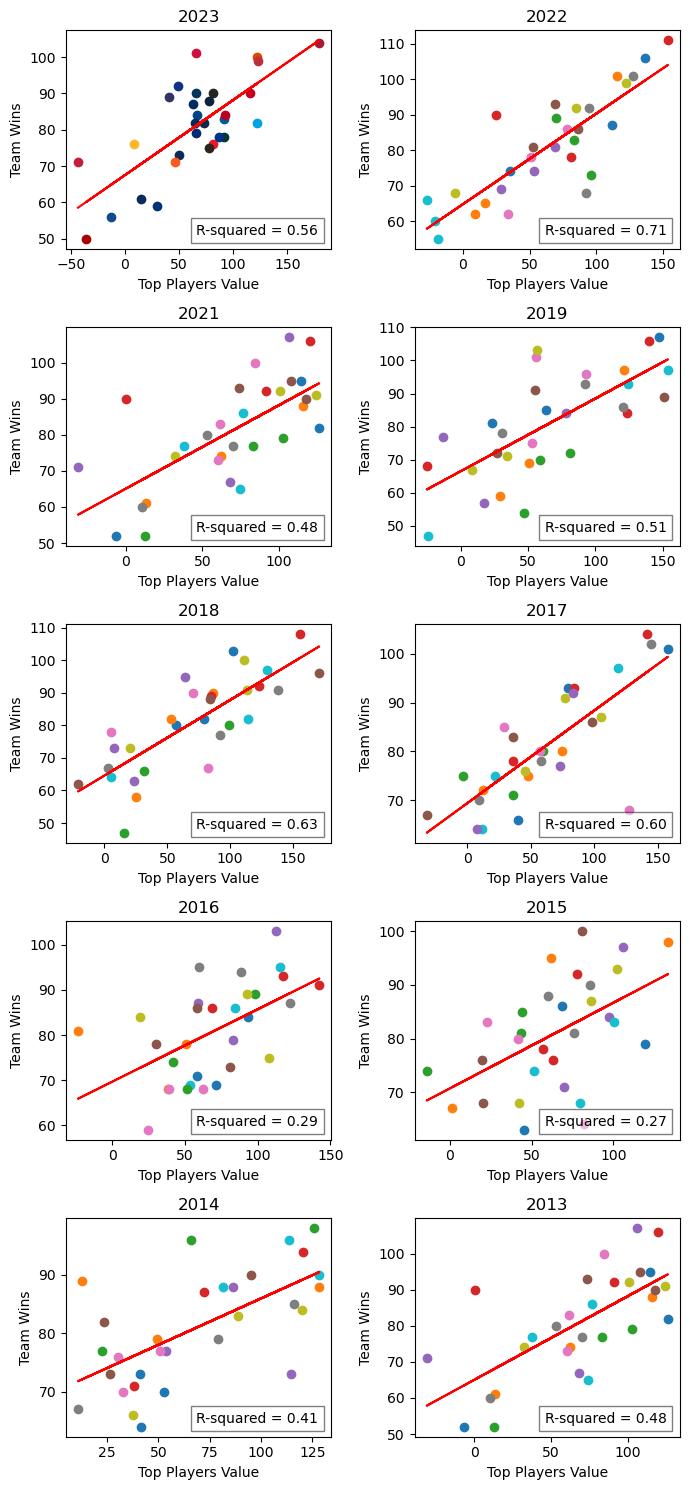

In [23]:
fig, axs = plt.subplots(5, 2, figsize=(7, 15))

colors = ['#A71930', '#CE1141', '#DF4601', '#BD3039', '#0E3386', '#27251F', '#C6011F', '#00385D', '#333366', '#0C2340', '#002D62', '#004687', '#BA0021', '#005A9C', '#00A3E0', '#12284B', '#002B5C', '#002D72', '#003087', '#003831', '#E81828', '#FDB827', '#2F241D', '#0C2C56', '#FD5A1E', '#C41E3A', '#092C5C', '#003278', '#134A8E', '#AB0003']  # Define colors
standings23alpha = standings23.sort_values(by='Tm', ascending=True)

for i, row in standings23alpha.iterrows():
    #     axs[0][0].plot(row['W'], row['Top5HitterValue'], marker='o', color=colors[i])
    #     axs[0][0].plot(row['W'], row["Top5PitcherValue"], marker='v', color=colors[i])
    axs[0][0].plot(row['TotalValue'], row['W'], marker='o', color=colors[i])

# Plot the line of best fit
x = standings23alpha['TotalValue'] 
y = standings23alpha['W']
m, b = np.polyfit(x, y, 1)
axs[0][0].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[0][0].set_ylabel('Team Wins')
axs[0][0].set_xlabel('Top Players Value')
axs[0][0].set_title('2023')
axs[0][0].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fontsize=10, ha='right', va='bottom', transform=axs[0][0].transAxes, bbox=dict(facecolor='white', alpha=0.5))



standings22alpha = standings22.sort_values(by='Tm', ascending=True)
standings22.shape[0]

for i, row in standings22alpha.iterrows():
    axs[0][1].plot(row['TotalValue'], row['W'], marker='o')

# Plot the line of best fit
x = standings22alpha['TotalValue'] 
y = standings22alpha['W']
m, b = np.polyfit(x, y, 1)
axs[0][1].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[0][1].set_ylabel('Team Wins')
axs[0][1].set_xlabel('Top Players Value')
axs[0][1].set_title('2022')
axs[0][1].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fontsize=10, ha='right', va='bottom', transform=axs[0][1].transAxes, bbox=dict(facecolor='white', alpha=0.5))




standings21alpha = standings21.sort_values(by='Tm', ascending=True)

for i, row in standings21alpha.iterrows():
    axs[1][0].plot(row['TotalValue'], row['W'], marker='o')

# Plot the line of best fit
x = standings21alpha['TotalValue'] 
y = standings21alpha['W']
m, b = np.polyfit(x, y, 1)
axs[1][0].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[1][0].set_ylabel('Team Wins')
axs[1][0].set_xlabel('Top Players Value')
axs[1][0].set_title('2021')
axs[1][0].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fontsize=10, ha='right', va='bottom', transform=axs[1][0].transAxes, bbox=dict(facecolor='white', alpha=0.5))




standings19alpha = standings19.sort_values(by='Tm', ascending= True)

for i, row in standings19alpha.iterrows():
    axs[1][1].plot(row['TotalValue'], row['W'], marker='o')

# Plot the line of best fit
x = standings19alpha['TotalValue'] 
y = standings19alpha['W']
m, b = np.polyfit(x, y, 1)
axs[1][1].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[1][1].set_ylabel('Team Wins')
axs[1][1].set_xlabel('Top Players Value')
axs[1][1].set_title('2019')
axs[1][1].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fontsize=10, ha='right', va='bottom', transform=axs[1][1].transAxes, bbox=dict(facecolor='white', alpha=0.5))



standings18alpha = standings18.sort_values(by='Tm', ascending= True)

for i, row in standings18alpha.iterrows():
    axs[2][0].plot(row['TotalValue'], row['W'], marker='o')

# Plot the line of best fit
x = standings18alpha['TotalValue'] 
y = standings18alpha['W']
m, b = np.polyfit(x, y, 1)
axs[2][0].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[2][0].set_ylabel('Team Wins')
axs[2][0].set_xlabel('Top Players Value')
axs[2][0].set_title('2018')
axs[2][0].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fontsize=10, ha='right', va='bottom', transform=axs[2][0].transAxes, bbox=dict(facecolor='white', alpha=0.5))



standings17alpha = standings17.sort_values(by='Tm', ascending= True)

for i, row in standings17alpha.iterrows():
    axs[2][1].plot(row['TotalValue'], row['W'], marker='o')

# Plot the line of best fit
x = standings17alpha['TotalValue'] 
y = standings17alpha['W']
m, b = np.polyfit(x, y, 1)
axs[2][1].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[2][1].set_ylabel('Team Wins')
axs[2][1].set_xlabel('Top Players Value')
axs[2][1].set_title('2017')
axs[2][1].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fontsize=10, ha='right', va='bottom', transform=axs[2][1].transAxes, bbox=dict(facecolor='white', alpha=0.5))



standings16alpha = standings16.sort_values(by='Tm', ascending= True)

for i, row in standings16alpha.iterrows():
    axs[3][0].plot(row['TotalValue'], row['W'], marker='o')

# Plot the line of best fit
x = standings16alpha['TotalValue'] 
y = standings16alpha['W']
m, b = np.polyfit(x, y, 1)
axs[3][0].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[3][0].set_ylabel('Team Wins')
axs[3][0].set_xlabel('Top Players Value')
axs[3][0].set_title('2016')
axs[3][0].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fontsize=10, ha='right', va='bottom', transform=axs[3][0].transAxes, bbox=dict(facecolor='white', alpha=0.5))



standings15alpha = standings15.sort_values(by='Tm', ascending= True)

for i, row in standings15alpha.iterrows():
    axs[3][1].plot(row['TotalValue'], row['W'], marker='o')

# Plot the line of best fit
x = standings15alpha['TotalValue'] 
y = standings15alpha['W']
m, b = np.polyfit(x, y, 1)
axs[3][1].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[3][1].set_ylabel('Team Wins')
axs[3][1].set_xlabel('Top Players Value')
axs[3][1].set_title('2015')
axs[3][1].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fontsize=10, ha='right', va='bottom', transform=axs[3][1].transAxes, bbox=dict(facecolor='white', alpha=0.5))



standings14alpha = standings14.sort_values(by='Tm', ascending= True)

for i, row in standings14alpha.iterrows():
    axs[4][0].plot(row['TotalValue'], row['W'], marker='o')

# Plot the line of best fit
x = standings14alpha['TotalValue'] 
y = standings14alpha['W']
m, b = np.polyfit(x, y, 1)
axs[4][0].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[4][0].set_ylabel('Team Wins')
axs[4][0].set_xlabel('Top Players Value')
axs[4][0].set_title('2014')
axs[4][0].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fontsize=10, ha='right', va='bottom', transform=axs[4][0].transAxes, bbox=dict(facecolor='white', alpha=0.5))



standings13alpha = standings21.sort_values(by='Tm', ascending= True)

for i, row in standings13alpha.iterrows():
    axs[4][1].plot(row['TotalValue'], row['W'], marker='o')

# Plot the line of best fit
x = standings13alpha['TotalValue'] 
y = standings13alpha['W']
m, b = np.polyfit(x, y, 1)
axs[4][1].plot(x, m*x + b, color='red', label='Line of Best Fit')

# Calculate R-squared
y_pred = m*x + b
r_squared = r2_score(y, y_pred)

# Add text to plot
axs[4][1].set_ylabel('Team Wins')
axs[4][1].set_xlabel('Top Players Value')
axs[4][1].set_title('2013')
axs[4][1].text(0.95, 0.05, 'R-squared = {:.2f}'.format(r_squared), fon
               tsize=10, ha='right', va='bottom', transform=axs[4][1].transAxes, bbox=dict(facecolor='white', alpha=0.5))


plt.tight_layout()
plt.show()

 Colors provided by: https://teamcolorcodes.com/mlb-color-codes/

# Conclusion

From the graphs, it's evident that this method of estimating win totals isn't particularly effective, with the highest R-squared value reaching only 0.71, and half of the R-squared values falling below 0.5.

Upon running this model with various sets of 1000 randomly created weights for both hitting and pitching stats (See Perfect Params Notebook), several commonalities have emerged. Notably, the year 2022 appears to be more predictable using this method compared to other years, as all 10 of the highest R-squared values are from 2022. However, even in this year, the highest R-squared value attained is approximately 0.86, which is still not considered high. The top-performing models consistently assigned hitting weights of over 20% to Hits, while pitching weights of over 20% were assigned to HR9 and BB9, and SO9 under 5%.

This pattern is logical, as a team's likelihood of winning increases with the number of hits they accumulate, leading to more runs and ultimately victories. On the pitching side, minimizing walks is crucial, as walks cannot be defended against regardless of a team's defensive prowess. Additionally, limiting home runs is vital, as they directly result in runs. Interestingly, per nine inning values that were unaffected by endurance proved to be more influential than those that were.

Perhaps the most intriguing discovery is the absence of overlap between what renders hitters more valuable and what makes pitchers more valuable. In theory, the best pitchers would counteract factors that enhance hitters' value, while hitters would exploit aspects that diminish pitchers' value.